In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from gluonts.dataset.common import ListDataset
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx.distribution.mixture import MixtureDistribution
from gluonts.mx.distribution.multivariate_gaussian import MultivariateGaussian
from gluonts.mx import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.wavenet import WaveNetEstimator
from gluonts.evaluation import make_evaluation_predictions

import warnings
warnings.filterwarnings("ignore")

/home/resifis/miniconda3/lib/python3.9/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
data = pd.read_csv("specific_location.csv")
data = data.set_index("Unnamed: 0")

In [3]:
data["prevGHI"] = data["GHI(W/m2)"].shift(1)
data["GHI_changerate"] = (data["GHI(W/m2)"]-data["prevGHI"])/(data["prevGHI"])





data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

In [4]:
test_data = data["2016:01:01 00:00:00":]
data = data[:"2016:01:01 00:00:00"]

# Prepare Input Data

In [5]:
freq = "1H"             # the frequency of our data, here daily
context_length    = 500 # train on this number of days
prediction_length =  50 # predict these many days, these are removed from the end of the training data
cols = ["mslp(hPa)","t2(C)","wind_speed(m/s)","rh(%)","SWDIR(W/m2)","rain(mm)","AOD"]

In [6]:
train_target = data[["GHI(W/m2)"]]
train_target["timestamp"] = train_target.index
train_target = train_target.set_index("timestamp")
train_target.index = pd.to_datetime(train_target.index)

In [7]:
train_features = data[cols]
test_features = test_data[cols]

In [8]:
test_target = test_data[["GHI(W/m2)"]]
test_target["timestamp"] = test_target.index
test_target = test_target.set_index("timestamp")
test_target.index = pd.to_datetime(test_target.index)

In [9]:
#train_list = [{"start": "2008-01-01 06:00:00", "target": train_target[c].values} for c in train_target.columns]
#test_list = [{"start": test_target.index.tolist()[0], "target": test_target[c].values} for c in test_target.columns]
#train_ds = ListDataset(data_iter=train_list,freq="1H")
#test_ds =  ListDataset(data_iter=test_list,freq="1H")

In [10]:
from gluonts.dataset.field_names import FieldName
train_ds = ListDataset([{FieldName.TARGET: train_target["GHI(W/m2)"].values,
                         FieldName.START: "2008-01-01 06:00:00",
                         FieldName.FEAT_DYNAMIC_REAL: train_features.values}],
                       freq = "1H")
test_ds = ListDataset([{FieldName.TARGET: test_target["GHI(W/m2)"].values,
                         FieldName.START: test_target.index.tolist()[0],
                         FieldName.FEAT_DYNAMIC_REAL: test_features.values}],
                       freq = "1H")


# Probabilistic Model : DeepAR

In [13]:
estimator = TransformerEstimator(freq=freq,
                            context_length=context_length,
                            prediction_length=prediction_length,
                            distr_output=StudentTOutput(),
                            trainer=Trainer(epochs=50,
                                           batch_size = 256,
                                           learning_rate=1e-3,                                                       
                                           num_batches_per_epoch=100,
                                           patience=10))

In [14]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [01:02<00:00,  1.61it/s, epoch=50/50, avg_epoch_loss=4.4]


# Evaluation

In [15]:
import matplotlib.pyplot as plt
def plot_prob_forecasts(title, ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (80.0, 99.0)
    legend = ["ground truth", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(25,10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='red')
    plt.axvline(forecast_entry.start_date, color='g', lw=1) # end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.title(title)
    plt.show()

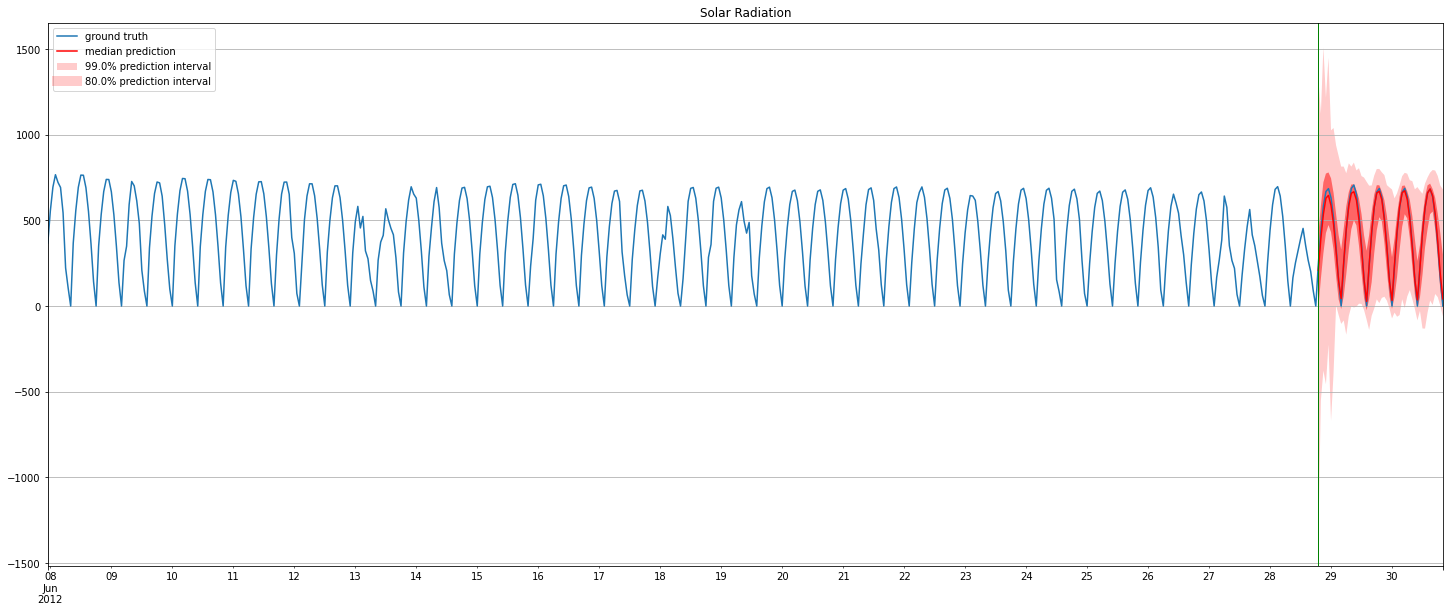

In [16]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,     # dataset
    predictor=predictor,  # predictor
    num_samples=2000,     # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts("Solar Radiation", tss[0], forecasts[0])

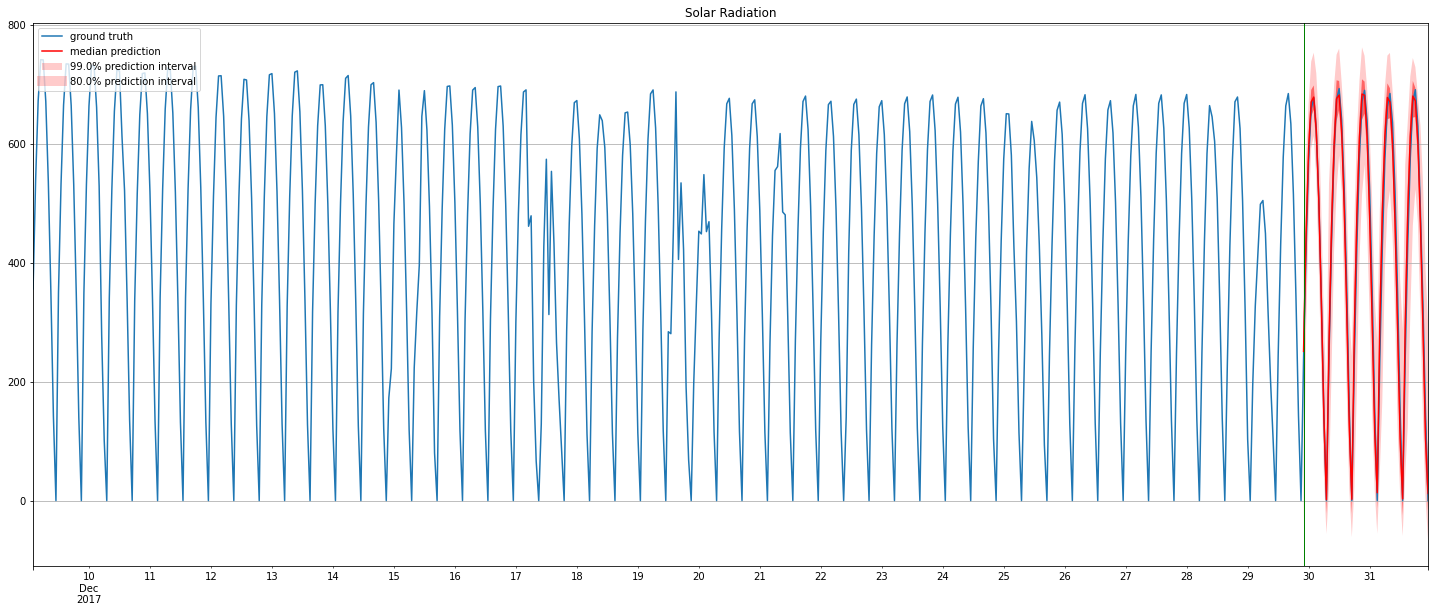

In [17]:
predictor.predict(test_ds)
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,     # dataset
    predictor=predictor,  # predictor
    num_samples=2000,     # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts("Solar Radiation", tss[0], forecasts[0])

In [18]:
from gluonts.evaluation import Evaluator

In [19]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 1it [00:00,  1.62it/s]


In [21]:
agg_metrics

{'MSE': 852.814296875,
 'abs_error': 1273.3685302734375,
 'abs_target_sum': 21203.3671875,
 'abs_target_mean': 424.06734375,
 'seasonal_error': 289.24737903225804,
 'MASE': 0.08804702290017476,
 'MAPE': 0.08256123860677084,
 'sMAPE': 0.2764407539367676,
 'MSIS': 0.5579589168165854,
 'QuantileLoss[0.1]': 423.50618667602544,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 1273.368706703186,
 'Coverage[0.5]': 0.52,
 'QuantileLoss[0.9]': 433.1277309417724,
 'Coverage[0.9]': 0.92,
 'RMSE': 29.20298438302154,
 'NRMSE': 0.06886402552194056,
 'ND': 0.06005501480086263,
 'wQuantileLoss[0.1]': 0.01997353453019927,
 'wQuantileLoss[0.5]': 0.06005502312169898,
 'wQuantileLoss[0.9]': 0.020427308885030006,
 'mean_absolute_QuantileLoss': 710.0008747736614,
 'mean_wQuantileLoss': 0.03348528884564275,
 'MAE_Coverage': 0.04666666666666668,
 'OWA': nan}